In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [23]:
C, CJ, Csh, Lq, Lr, Δ, EJ = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=False))
CR, CF, LF, LR, EJ, Δ, ω_r = (
    sq_ext.get_experimental_parameters('qubit_1', return_effective=True))
C_prime, CJ_prime, Csh_prime, Lq_prime, Lr_prime, Δ_prime, EJ_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=False))
CR_prime, CF_prime, LF_prime, LR_prime, EJ_prime, Δ_prime, ω_r_prime = (
    sq_ext.get_experimental_parameters('qubit_2', return_effective=True))

LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)[2]
LC_prime = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq_prime , Lr_prime , Δ_prime )[2]

In [4]:
nmax_r = 10
nmax_f = 10
only_inner = False
compensate_extra_cap = False
only_renormalization = False
n_eig = 6
φ_ext = 0.5
φ_ext_prime = 0.5

## Full circuit effective Hamiltonian

In [5]:
n_eig  = 5
n_plot = 20
CC_values = np.geomspace(1e-4,2e2, n_plot)

N_elements = 4
basis_states = [(0,0,0,0), (1,0,0,0), (0,0,1,0), (1,0,1,0)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low  = [f'({i},{j},{k},{l})' for i, j, k, l in basis_states]
labels_high = [f'({i},{j},{k},{l})' for i, j, k, l in mediating_states]

n_eig_extra_low = 2

In [6]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
H_eff_p2_decomp_list = []
ω_f_0      = np.zeros(len(CC_values))
ω_r_0      = np.zeros(len(CC_values))
g_r_limit  = np.zeros(len(CC_values))
g_fq_limit = np.zeros(len(CC_values))
g_xx_pert  = np.zeros(len(CC_values), dtype='complex')
g_zz_pert  = np.zeros(len(CC_values), dtype='complex')
g_yy_pert  = np.zeros(len(CC_values), dtype='complex')
X          = np.zeros(len(CC_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(CC_values), 4])
C_inv_coupling = np.zeros([len(CC_values)])

for i, CC in enumerate(CC_values):
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization)
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    C_inv_coupling[i] = np.abs(C_inv_qubit_C_qubit[0,2])
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    
    circuits = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    LCs = [LC, LC_prime]
    
    H = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits, LCs, nmax_r=nmax_r, nmax_f=nmax_f)
    H_0_list = [circuit.hamiltonian() for circuit in circuits]
    
    P1, P2, SWT, H_eff_p2_decomp = sq_ext.H_eff_4x4(H_0_list, H, basis_states, mediating_states, n_eig, return_decomposition=True)
    Pauli_p1.append(P1)
    Pauli_p2.append(P2)
    Pauli_SWT.append(SWT)
    H_eff_p2_decomp_list.append(H_eff_p2_decomp)

Pauli_p1 = np.array(Pauli_p1)
Pauli_p2 = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

In [7]:
Pauli_p1_full  = Pauli_p1 
Pauli_p2_full  = Pauli_p2 
Pauli_SWT_full = Pauli_SWT

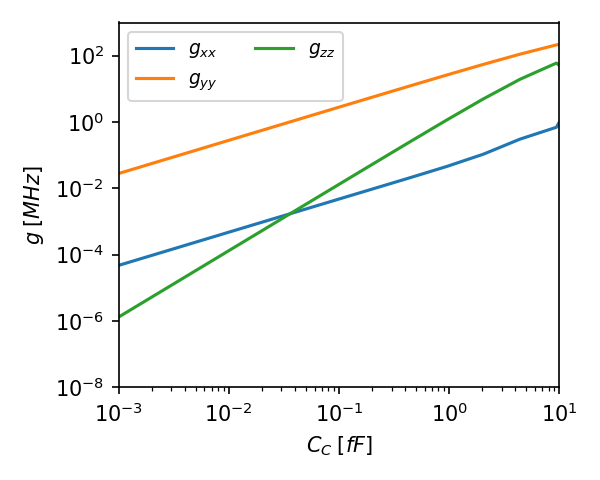

In [8]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True


for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
    # if i ==2:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(CC_values, σxσx * 1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(CC_values, σyσy * 1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(CC_values, σzσz * 1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')
    

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-8,1e3])
ax1.set_xlim([1e-3,1e1])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$C_C\; [fF]$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_qubit_C_qubit_vs_Cc.pdf', fig)
fig.show()

C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


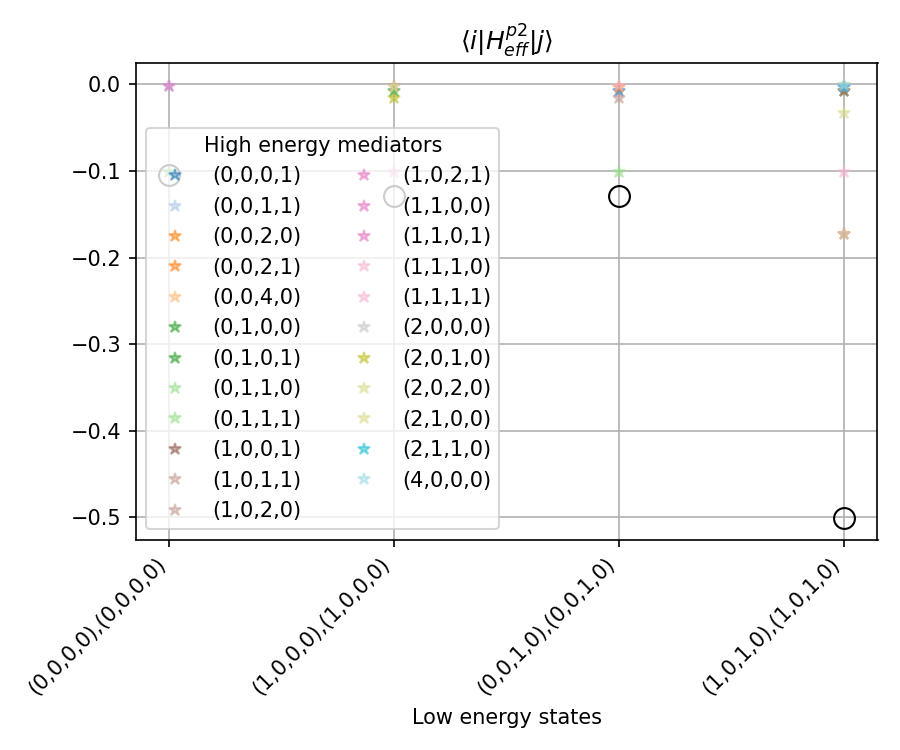

In [9]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomp_list[15], labels_low, labels_high, figsize=np.array([6, 5]) * 1,threshold=1e-4)

## Qubit-Qubit effective Hamiltonian

In [10]:
n_eig  = 5
# n_plot = 20
# CC_values = np.geomspace(1e-4,2e2)

N_elements = 2
basis_states = [(0,0), (1,0), (0,1), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [11]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(CC_values))
ω_r_0      = np.zeros(len(CC_values))
g_r_limit  = np.zeros(len(CC_values))
g_fq_limit = np.zeros(len(CC_values))
g_xx_pert  = np.zeros(len(CC_values), dtype='complex')
g_zz_pert  = np.zeros(len(CC_values), dtype='complex')
g_yy_pert  = np.zeros(len(CC_values), dtype='complex')
X          = np.zeros(len(CC_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(CC_values), 4])
C_inv_coupling = np.zeros([len(CC_values)])

for i, CC in enumerate(CC_values):
    C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization)
    C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
    C_inv_coupling[i] = np.abs(C_inv_qubit_C_qubit[0,2])
    CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
    CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
    CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
    CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1
    
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext_prime)
    resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)
    
    # circuits = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    LCs = [LC, LC_prime]

    H_0, H = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], [fluxonium,fluxonium_prime], nmax_f=nmax_f,return_H_0=True )

    H1 = fluxonium.hamiltonian()
    H2 = fluxonium_prime.hamiltonian()
    H_0_list = [H1, H2]
    
    P1, P2, SWT = sq_ext.H_eff_4x4(H_0_list, H, basis_states, mediating_states, n_eig)
    Pauli_p1.append(P1)
    Pauli_p2.append(P2)
    Pauli_SWT.append(SWT)

    fluxonium.diag(3);
    fluxonium_prime.diag(3);
    omega_1 = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_2 = fluxonium_prime.efreqs[1]-fluxonium_prime.efreqs[0]
    alpha_1 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    alpha_2 = fluxonium_prime.efreqs[2]-fluxonium_prime.efreqs[1]
       
    Q_f1 = fluxonium.charge_op(0, basis='eig')
    Q_f2 = fluxonium_prime.charge_op(0, basis='eig')
    
    g_yy_pert[i] = C_inv_qubit_C_qubit[0,2] * fF **-1  *  Q_f1[0,1]*Q_f2[0,1] / (2*np.pi*GHz)
    g_zz_pert[i] =   -( (C_inv_qubit_C_qubit[0,2] * fF **-1)**2 * ( 
                Q_f1[1,2]**2 * Q_f2[0,1]**2/(+alpha_1+omega_2) +
                Q_f1[0,1]**2 * Q_f2[1,2]**2/(+omega_1+alpha_2) +
                Q_f1[1,2]**2 * Q_f2[1,2]**2/(-alpha_1-alpha_2) +
                Q_f1[1,2]**2 * Q_f2[0,1]**2/(-alpha_1+omega_2) +
                Q_f1[0,1]**2 * Q_f2[1,2]**2/(+omega_1-alpha_2)  
                 )/ (2*np.pi*GHz)**2) / 4
    
Pauli_p1 = np.array(Pauli_p1)
Pauli_p2 = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

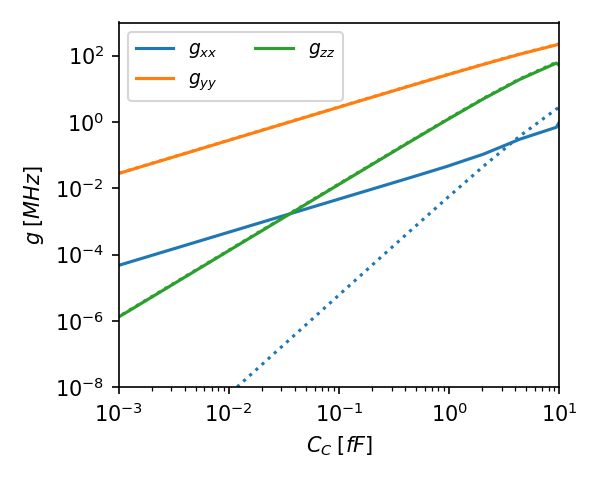

In [12]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True


for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
    # if i ==2:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    σxσx_full = np.abs(Pauli_SWT_full[:, 1,1])
    σyσy_full = np.abs(Pauli_SWT_full[:, 2,2])
    σzσz_full = np.abs(Pauli_SWT_full[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])
    
    ax1.plot(CC_values, σxσx_full * 1e3, color = colors[0], linestyle='-', label = r'$g_{xx}$')
    ax1.plot(CC_values, σyσy_full * 1e3, color = colors[1], linestyle='-', label = r'$g_{yy}$')
    ax1.plot(CC_values, σzσz_full * 1e3, color = colors[2], linestyle='-', label = r'$g_{zz}$')

    ax1.plot(CC_values, σxσx * 1e3, color = colors[0], linestyle=':' )
    ax1.plot(CC_values, σyσy * 1e3, color = colors[1], linestyle=':' )
    ax1.plot(CC_values, σzσz * 1e3, color = colors[2], linestyle=':' )
    # ax1.plot(CC_values[::4], g_yy_pert[::4] * 1e3, 'o', color = colors[1],   markersize='4')
    # ax1.plot(CC_values[::4], g_zz_pert[::4] * 1e3,'o', color = colors[2],markersize='4')
    

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-8,1e3])
ax1.set_xlim([1e-3,1e1])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$C_C\; [fF]$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_QR_C_QR_vs_Cc.pdf', fig)
fig.show()

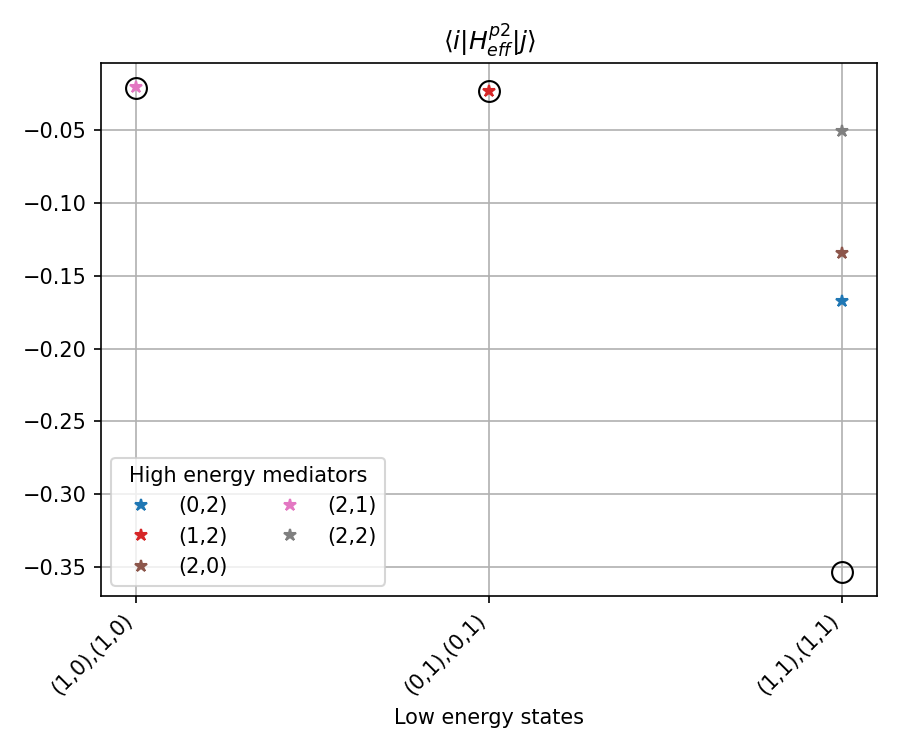

In [140]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high, figsize=np.array([6, 5]) * 1,threshold=1e-3)

## Vs phi ext

In [37]:
n_eig  = 5
n_plot = 50
φ_ext_values = np.linspace(0.5, 0.55, n_plot)
CC = 1

N_elements_uc = 4
basis_states_uc = [(0,0,0,0), (1,0,0,0), (0,0,1,0), (1,0,1,0)]
max_excitations_mediating_states_uc=3
mediating_states_uc = sq_ext.generate_mediating_states(N_elements_uc, basis_states_uc, max_excitations_mediating_states_uc)
labels_low_uc  = [f'({i},{j},{k},{l})' for i, j, k, l in basis_states_uc]
labels_high_uc = [f'({i},{j},{k},{l})' for i, j, k, l in mediating_states_uc]
n_eig_extra_low_uc = 2

N_elements_f = 2
basis_states_f = [(0,0), (1,0), (0,1), (1,1)]
max_excitations_mediating_states_f = 4
mediating_states_f = sq_ext.generate_mediating_states(N_elements_f, basis_states_f, max_excitations_mediating_states_f)
labels_low_f = [f'({i},{j})' for i, j in basis_states_f]
labels_high_f = [f'({i},{j})' for i, j in mediating_states_f]
n_eig_extra_low_f = 2


In [38]:
C_mat_qubit_C_qubit = sq_ext.C_mat_qubit_C_qubit(CC, CR, CF, CR_prime, CF_prime, only_inner, compensate_extra_cap, only_renormalization)
C_inv_qubit_C_qubit = np.linalg.inv(C_mat_qubit_C_qubit)
CF_tilde = C_inv_qubit_C_qubit[0, 0] ** -1
CR_tilde = C_inv_qubit_C_qubit[1, 1] ** -1
CF_prime_tilde = C_inv_qubit_C_qubit[2, 2] ** -1
CR_prime_tilde = C_inv_qubit_C_qubit[3, 3] ** -1

fluxonium_0 = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=0.5)
resonator = sq_ext.sq_resonator(C_R_eff=CR_tilde, L_R_eff=LR, Δ=Δ, EJ=EJ, nmax_r=nmax_r)
fluxonium_prime_0 = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=0.5)
resonator_prime = sq_ext.sq_resonator(C_R_eff=CR_prime_tilde, L_R_eff=LR_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_r=nmax_r)

LCs = [LC, LC_prime]

circuits_0_uc = [fluxonium_0, resonator, fluxonium_prime_0, resonator_prime]
H_0_list_uc = [circuit.hamiltonian() for circuit in circuits_0_uc]

circuits_0_f = [fluxonium_0, fluxonium_prime_0]
H_0_list_f = [circuit.hamiltonian() for circuit in circuits_0_f]

In [39]:
Pauli_p1_uc  = np.zeros([len(φ_ext_values),4,4])
Pauli_p2_uc  = np.zeros([len(φ_ext_values),4,4])
Pauli_SWT_uc = np.zeros([len(φ_ext_values),4,4])
E_uc         = np.zeros([len(φ_ext_values),4])

Pauli_p1_f  = np.zeros([len(φ_ext_values),4,4])
Pauli_p2_f  = np.zeros([len(φ_ext_values),4,4])
Pauli_SWT_f = np.zeros([len(φ_ext_values),4,4])
E_f         = np.zeros([len(φ_ext_values),4])

for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF_tilde, L_F_eff=LF, Δ=Δ, EJ=EJ, nmax_f=nmax_f, φ_ext=0.5)
    fluxonium_prime = sq_ext.sq_fluxonium(C_F_eff=CF_prime_tilde, L_F_eff=LF_prime, Δ=Δ_prime, EJ=EJ_prime, nmax_f=nmax_f, φ_ext=φ_ext)
    
    circuits_uc = [fluxonium, resonator, fluxonium_prime, resonator_prime]
    H_uc = sq_ext.hamiltonian_qubit_C_qubit(C_inv_qubit_C_qubit, circuits_uc, LCs, nmax_r=nmax_r, nmax_f=nmax_f)
    Pauli_p1_uc[i,:], Pauli_p2_uc[i,:], Pauli_SWT_uc[i,:], H_eff_p2_decomp_uc, E_uc[i] =\
        sq_ext.H_eff_4x4(H_0_list_uc, H_uc, basis_states_uc, mediating_states_uc, n_eig, return_decomposition=True, return_E=True)
    
    circuits_f = [fluxonium, fluxonium_prime]
    H_f = sq_ext.hamiltonian_fluxonium_C_fluxonium(C_inv_qubit_C_qubit[[0,2],:][:,[0,2]], circuits_f, nmax_f=nmax_f)
    Pauli_p1_f[i,:], Pauli_p2_f[i,:], Pauli_SWT_f[i,:], H_eff_p2_decomp_f, E_f[i]  =\
        sq_ext.H_eff_4x4(H_0_list_f, H_f, basis_states_f, mediating_states_f, n_eig, return_decomposition=True, return_E=True)
    

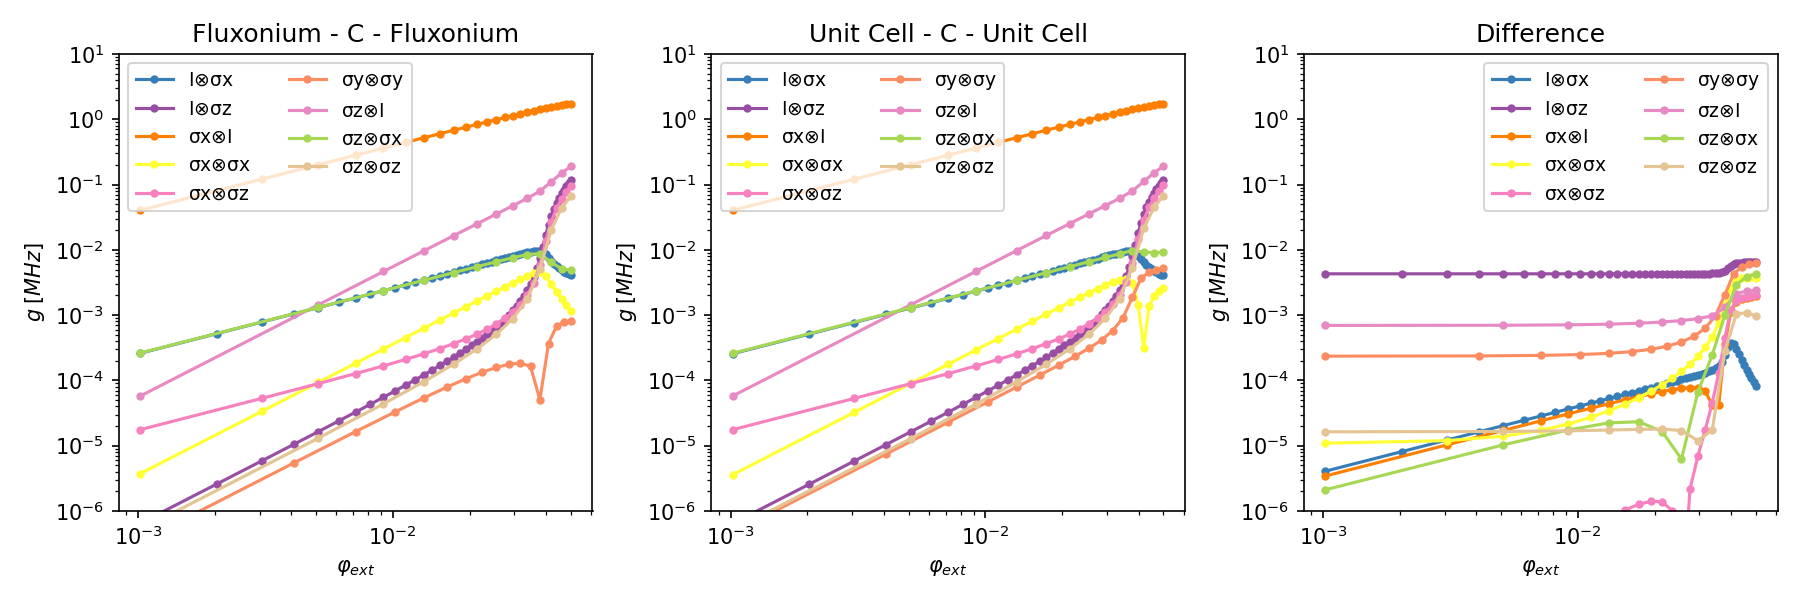

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, dpi=150, figsize=[12,4])
linestyles = ['-', '--','-' ]
labels = ['I', 'σx', 'σy', 'σz']
# colors = figs.generate_colors_from_colormap(16, 'tab20')
colors = figs.generate_colors_from_colormap(9, 'Set1') + figs.generate_colors_from_colormap(9, 'Set2')

Pauli_decomp_uc = Pauli_SWT_uc
Pauli_decomp_f = Pauli_SWT_f

for i in range(4):
    for j in range(4):
        if i==j==0:
            continue
        if np.any( np.abs(Pauli_decomp_f[1:,i,j]- Pauli_decomp_f[0,i,j]) >1e-12):
            ax1.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp_f[1:,i,j]- Pauli_decomp_f[0,i,j])[::i+1],color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}', marker='.' )
            
            ax3.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp_f[1:,i,j]- Pauli_decomp_uc[1:,i,j])[::i+1],color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}', marker='.'  )
            
        if np.any( np.abs(Pauli_decomp_uc[1:,i,j]- Pauli_decomp_uc[0,i,j]) >1e-12):
            ax2.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp_uc[1:,i,j]- Pauli_decomp_uc[0,i,j])[::i+1],color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}' , marker='.' )

for ax in [ax1, ax2, ax3]:
    ax.legend(ncol=2, fontsize=9)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-6,1e1)
    ax.set_ylabel('$g \; [MHz]$')
    ax.set_xlabel(r'$\varphi_{ext}$')

ax1.set_title('Fluxonium - C - Fluxonium')
ax2.set_title('Unit Cell - C - Unit Cell')
ax3.set_title('Difference')

fig.tight_layout()

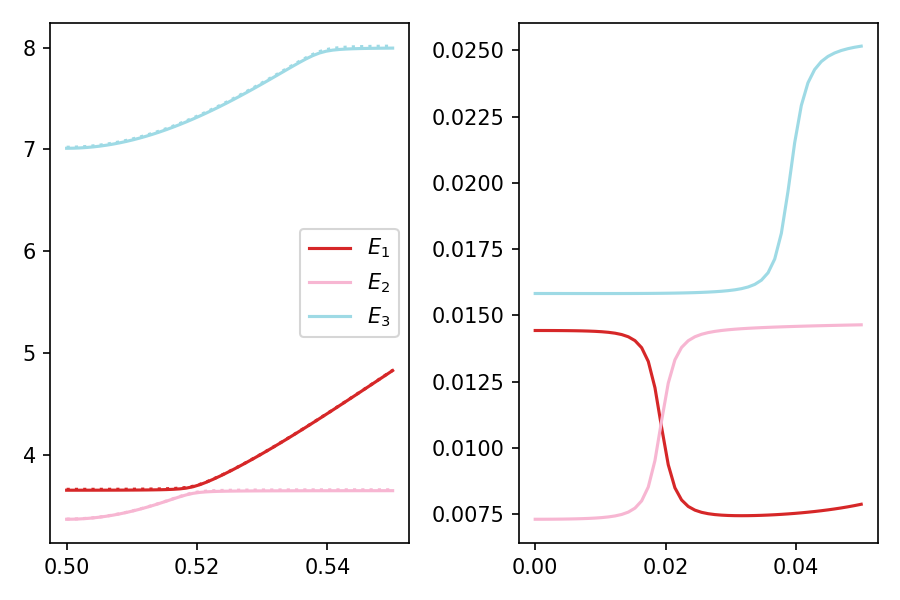

In [41]:
colors = figs.generate_colors_from_colormap(4, 'tab20')

fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=150, figsize=[6,4])

for i in range(1,4):
    ax1.plot(φ_ext_values, E_uc[:,i]-E_uc[:,0], color=colors[i], label=f'$E_{i}$' )
    ax1.plot(φ_ext_values, E_f[:,i]-E_f[:,0], ':', color=colors[i])
    
    ax2.plot(φ_ext_values-0.5, np.abs(E_f[:,i]-E_uc[:,i]), color=colors[i])
    
# ax2.set_yscale('log')
# ax2.set_xscale('log')
ax1.legend()
fig.tight_layout()